# **CNN 모델링_실습**


## **1.환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchsummary import summary

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [3]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long = int64
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # 전체 데이터셋의 크기
    num_batches = len(dataloader) # 배치의 수
    tr_loss = 0                  # tr loss 0으로 초기화
    model.train()                                   # 훈련 모드로 설정(드롭아웃 및 배치 정규화와 같은 계층을 훈련 모드로 변경)
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # X.to(device), y.to(device): 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 이동

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [5]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

In [6]:
def evaluate_2(dataloader, model, loss_fn, device):
    model.eval()
    total_loss = 0
    preds = []
    trues = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds.append(outputs)
            trues.append(labels)

    preds = torch.cat(preds)
    trues = torch.cat(trues)

    return total_loss / len(dataloader), preds, trues

* 학습곡선

In [7]:
def dl_learning_curve(tr_loss_list, val_loss_list, val_acc_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')
    plt.plot(epochs, val_acc_list, label='val_acc', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [8]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### (4) 데이터 셋

#### 1) 다운로드

In [9]:
# github img 데이터셋 불러오기
!wget https://github.com/suku-7/AICE-Pro-share/raw/main/Flower_Classification_5class.zip

--2025-04-19 12:10:10--  https://github.com/suku-7/AICE-Pro-share/raw/main/Flower_Classification_5class.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/suku-7/AICE-Pro-share/main/Flower_Classification_5class.zip [following]
--2025-04-19 12:10:11--  https://media.githubusercontent.com/media/suku-7/AICE-Pro-share/main/Flower_Classification_5class.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229731827 (219M) [application/zip]
Saving to: ‘Flower_Classification_5class.zip’

Flower_Classificati 100%[===================>] 219.09M   371MB/s    in 0.6s    

2025-04-19 12:10

In [10]:
# Colab 환경에서 압축 파일 업로드했기에 사용한 부분입니다.
!unzip Flower_Classification_5class.zip -d /content/

Archive:  Flower_Classification_5class.zip
  inflating: /content/flowers/flowers/flower_photos/test/daisy/10172379554_b296050f82_n.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/1306119996_ab8ae14d72_n.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/134409839_71069a95d1_m.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/19813618946_93818db7aa_m.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/3338077096_3a8ed0e2bc_m.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/3552074420_2a0a7166db_m.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/4141147800_813f660b47.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/538920244_59899a78f8_n.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/5973488341_50bdf6cee3_n.jpg  
  inflating: /content/flowers/flowers/flower_photos/test/daisy/8446495985_f72d851482.jpg  
  inflating: /content/flowers/f

In [11]:
# img flower_photos에 데이터셋 종류 확인
!ls -l /content/flowers/flowers/flower_photos

total 12
drwxr-xr-x 7 root root 4096 Apr 19 12:10 test
drwxr-xr-x 7 root root 4096 Apr 19 12:10 train
drwxr-xr-x 7 root root 4096 Apr 19 12:10 validation


In [12]:
# img jpg, jpeg, png, gif 뭐가 있는지 확인
# 다른 데이터셋중에는 jpg, jpeg가 혼합되어 사용된 경우가 있었어서 확인하게 되었습니다.
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep jpg | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep jpeg | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep png | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep gif | wc -l

607
0
0
0


In [13]:
# img test 데이터셋 폴더내 daisy 갯수 및 이미지 풀네임 확인
!ls -l /content/flowers/flowers/flower_photos/test/daisy

total 396
-rw-r--r-- 1 root root 36410 Apr 18  2021 10172379554_b296050f82_n.jpg
-rw-r--r-- 1 root root 24463 Apr 18  2021 1306119996_ab8ae14d72_n.jpg
-rw-r--r-- 1 root root 31422 Apr 18  2021 134409839_71069a95d1_m.jpg
-rw-r--r-- 1 root root 24030 Apr 18  2021 19813618946_93818db7aa_m.jpg
-rw-r--r-- 1 root root 17466 Apr 18  2021 3338077096_3a8ed0e2bc_m.jpg
-rw-r--r-- 1 root root 15072 Apr 18  2021 3552074420_2a0a7166db_m.jpg
-rw-r--r-- 1 root root 70320 Apr 18  2021 4141147800_813f660b47.jpg
-rw-r--r-- 1 root root 43385 Apr 18  2021 538920244_59899a78f8_n.jpg
-rw-r--r-- 1 root root 40516 Apr 18  2021 5973488341_50bdf6cee3_n.jpg
-rw-r--r-- 1 root root 86338 Apr 18  2021 8446495985_f72d851482.jpg


In [14]:
# img train, valid 경로 지정
train_img_path = '/content/flowers/flowers/flower_photos/train/'
valid_img_path = '/content/flowers/flowers/flower_photos/validation/'

In [15]:
# 1. 변환 정의 (원하면 Resize, Normalize 등 추가 가능)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2. ImageFolder로 데이터셋 불러오기
train_dataset = ImageFolder(root=train_img_path, transform=transform)
valid_dataset = ImageFolder(root=valid_img_path, transform=transform)

# 3. DataLoader로 묶기
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


#### 2) 데이터셋 정보

* 데이터셋 일반 정보

In [16]:
train_dataset, valid_dataset

(Dataset ImageFolder
     Number of datapoints: 3540
     Root location: /content/flowers/flowers/flower_photos/train/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 80
     Root location: /content/flowers/flowers/flower_photos/validation/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

* 데이터셋의 x와 y

In [17]:
# 이미지 경로 및 라벨 수 확인
print(len(train_dataset))  # 전체 이미지 수
print(train_dataset.classes)  # 클래스 이름들
print(train_dataset.class_to_idx) # 클래스와 인덱스 매핑 확인
print(train_dataset.targets[:])  # 라벨 리스트

3540
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
# 첫 번째 이미지의 shape 확인 (ToTensor로 변환된 상태에서)
image, label = train_dataset[0]
print(image.shape)  # 예: torch.Size([3, H, W])
print(label)        # 예: 0 ~ n_class-1

torch.Size([3, 224, 224])
0


* y(target)의 클래스

In [19]:
classes = train_dataset.classes
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

* 데이터 이미지 확인

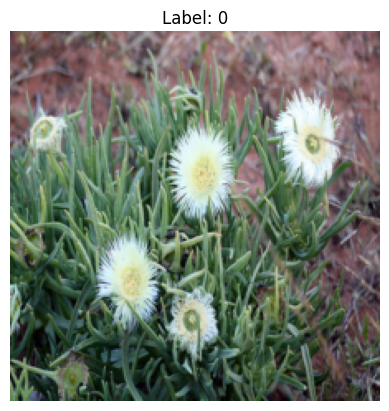

In [20]:
n = 10
image, label = train_dataset[n]  # 이미지와 라벨 불러오기

# 텐서를 넘파이로 바꿔서 시각화 (채널 차원 제거)
plt.imshow(image.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

## **3.모델링**

### (1) 모델 선언

In [21]:
n_class = 5 # 꽃 클래스 수

# 모델 구조 설계 (채널 수를 점차 줄이는 구조)
model = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),  # 3채널 입력
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),  # Dropout 추가

    nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),  # Dropout 추가

    nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),  # Dropout 추가

    nn.Flatten(),
    nn.Linear(32 * 28 * 28, 256),  # 224 → 112 → 56 → 28
    nn.ReLU(),
    nn.Dropout(0.2),  # Dropout 추가
    nn.Linear(256, n_class)
).to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           3,584
              ReLU-2        [-1, 128, 224, 224]               0
         MaxPool2d-3        [-1, 128, 112, 112]               0
           Dropout-4        [-1, 128, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          73,792
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
           Dropout-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]          18,464
             ReLU-10           [-1, 32, 56, 56]               0
        MaxPool2d-11           [-1, 32, 28, 28]               0
          Dropout-12           [-1, 32, 28, 28]               0
          Flatten-13                [-1, 25088]               0
           Linear-14                  [

### (2) 학습

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [24]:
epochs = 20
tr_loss_list, val_loss_list, val_acc_list = [], [], []

# early stopping을 위한 변수 설정 ----------------
patience = 5
best_loss = float('inf')  # 초기값을 무한대로 설정
counter = 0
# ------------------------------------------------

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, pred_logits, y_true = evaluate_2(valid_loader, model, loss_fn, device)
    pred = nn.functional.softmax(pred_logits, dim=1)
    pred = torch.argmax(pred, dim=1)

    acc = accuracy_score(y_true.cpu().numpy(), pred.cpu().numpy())

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(acc)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

    # early stopping 확인 -------------------
    if val_loss > best_loss:
            counter += 1
            print(f'--> early stopping status, best_loss : {best_loss:4f}, counter : {counter}')

    else:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # 💾 best 모델의 파라미터 저장
        print(f"✔️ Best model saved at epoch {t+1} with val loss: {best_loss:.4f}")  # ✅ 저장 메시지

    # 조기 종료 조건 확인
    if counter >= patience:
        print("Early Stopping!")
        break
    # ----------------------------------------

Epoch 1, train loss : 1.311058, val loss : 1.184627
✔️ Best model saved at epoch 1 with val loss: 1.1846
Epoch 2, train loss : 1.033728, val loss : 1.015058
✔️ Best model saved at epoch 2 with val loss: 1.0151
Epoch 3, train loss : 0.864411, val loss : 0.891047
✔️ Best model saved at epoch 3 with val loss: 0.8910
Epoch 4, train loss : 0.713271, val loss : 0.798205
✔️ Best model saved at epoch 4 with val loss: 0.7982
Epoch 5, train loss : 0.529932, val loss : 0.849962
--> early stopping status, best_loss : 0.798205, counter : 1
Epoch 6, train loss : 0.374283, val loss : 1.029819
--> early stopping status, best_loss : 0.798205, counter : 2
Epoch 7, train loss : 0.238091, val loss : 1.253357
--> early stopping status, best_loss : 0.798205, counter : 3
Epoch 8, train loss : 0.166192, val loss : 1.313072
--> early stopping status, best_loss : 0.798205, counter : 4
Epoch 9, train loss : 0.116407, val loss : 1.570201
--> early stopping status, best_loss : 0.798205, counter : 5
Early Stopping!

### (3) 모델 평가

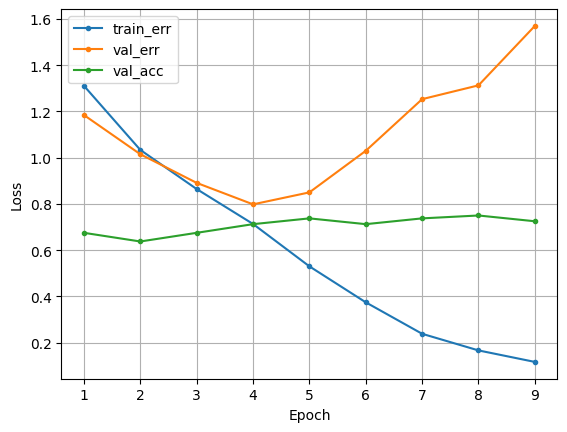

In [25]:
dl_learning_curve(tr_loss_list, val_loss_list, val_acc_list)

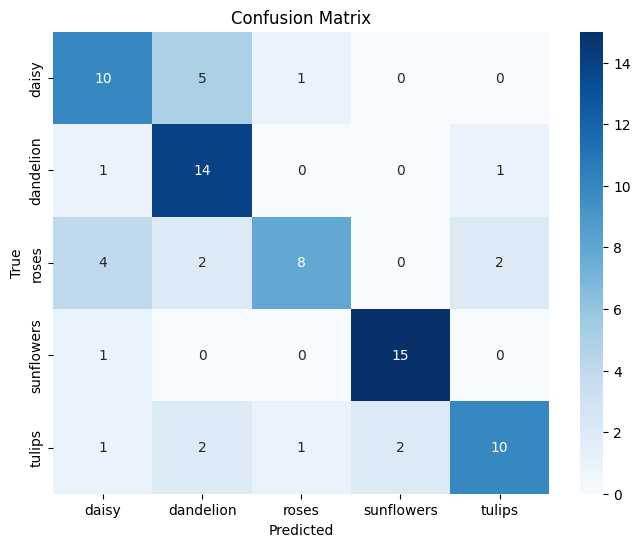

              precision    recall  f1-score   support

       daisy       0.59      0.62      0.61        16
   dandelion       0.61      0.88      0.72        16
       roses       0.80      0.50      0.62        16
  sunflowers       0.88      0.94      0.91        16
      tulips       0.77      0.62      0.69        16

    accuracy                           0.71        80
   macro avg       0.73      0.71      0.71        80
weighted avg       0.73      0.71      0.71        80

Predictions: [0 1 0 0 0 0 1 1 1 0 0 2 0 0 0 1 1 0 1 1 4 1 1 1 1 1 1 1 1 1 1 1 0 2 1 4 1
 2 2 2 0 4 2 0 2 0 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 4 3 2 4 4 4 4 4 4 4
 0 1 4 1 4 3]


In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 구조 설계 (채널 수를 점차 줄이는 구조)
model = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),  # 3채널 입력
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),  # Dropout 추가

    nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),  # Dropout 추가

    nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),  # Dropout 추가

    nn.Flatten(),
    nn.Linear(32 * 28 * 28, 256),  # 224 → 112 → 56 → 28
    nn.ReLU(),
    nn.Dropout(0.2),  # Dropout 추가
    nn.Linear(256, n_class)
).to(device)

# 저장된 모델 파라미터 불러오기
model.load_state_dict(torch.load('best_model.pt'))
model.eval()  # 평가 모드로 전환 (dropout, batch norm 등 끄기)

# 예측값을 계산하기 위해 valid_loader를 사용하여 예측을 수행
all_preds = []
all_true = []

with torch.no_grad():  # 예측할 때는 그래디언트 계산을 하지 않음
    for data, labels in valid_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)  # 모델 예측
        _, preds = torch.max(outputs, 1)  # 가장 높은 확률의 클래스 인덱스

        all_preds.append(preds.cpu().numpy())  # 예측값 저장
        all_true.append(labels.cpu().numpy())  # 실제값 저장

# 예측값과 실제값을 numpy array로 변환
all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

# confusion matrix 계산
cm = confusion_matrix(all_true, all_preds)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# classification_report 계산
report = classification_report(all_true, all_preds, target_names=classes)

# classification_report 출력
print(report)

# 예측값 출력
print(f"Predictions: {all_preds}")